# Newton-Bernstein aplicado al término viscoso unidimensional

Este cuaderno toma la derivación del algoritmo de `docs/04_algorithm.tex` y lo aplica al término viscoso unidimensional $$\nu \frac{\partial^2 u}{\partial y^2}$$. La idea es representar un perfil de velocidad con puntos de control de Bernstein y verificar que se obtiene la difusión esperada al calcular la segunda derivada de la interpolación.

## Término viscoso en 1D y en coordenadas cilíndricas

**En 1D (flujo $u(y)$ en la dirección $x$)**:

$$\nu \nabla^2 u = \nu \frac{\partial^2 u}{\partial y^2}$$

**En coordenadas cilíndricas (flujo $u_z(r)$)**:

$$\nu \nabla^2 u_z = \nu \frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial u_z}{\partial r}\right)$$

Nos quedamos con la primera identidad y sustituimos la variable transversal $y$ por una malla de nodos equiespaciados.

In [3]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

repo_root = Path.cwd()
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

from python.newton_bernstein_univariate import NewtonBernsteinUnivariate

nu = 1e-3

def analytic_velocity(y: np.ndarray) -> np.ndarray:
    return 1.0 - (y - 0.5) ** 2

num_nodes = 9
y_nodes = np.linspace(0.0, 1.0, num_nodes)
u_nodes = analytic_velocity(y_nodes)

nb = NewtonBernsteinUnivariate(y_nodes, u_nodes)
control_points = nb.algorithm_newton_bernstein()

y_dense = np.linspace(0.0, 1.0, 400)
u_dense = analytic_velocity(y_dense)
u_interp = nb.evaluate_bernstein(y_dense)
u_newton = nb.evaluate_newton(y_dense)
error_stats = nb.compute_error(y_dense, u_dense)

print('Puntos de control de Bernstein (truncados):')
print(np.round(control_points, 5))
print('\nErrores estadísticos frente al perfil analítico:')
print(f"  MSE  = {error_stats['MSE']:.3e}")
print(f"  RMSE = {error_stats['RMSE']:.3e}")
print(f"  MAE  = {error_stats['MAE']:.3e}")
print(f"  R²   = {error_stats['R2']:.5f}")

Puntos de control de Bernstein (truncados):
[0.75    0.875   0.96429 1.01786 1.03571 1.01786 0.96429 0.875   0.75   ]

Errores estadísticos frente al perfil analítico:
  MSE  = 5.316e-32
  RMSE = 2.306e-16
  MAE  = 1.557e-16
  R²   = 1.00000


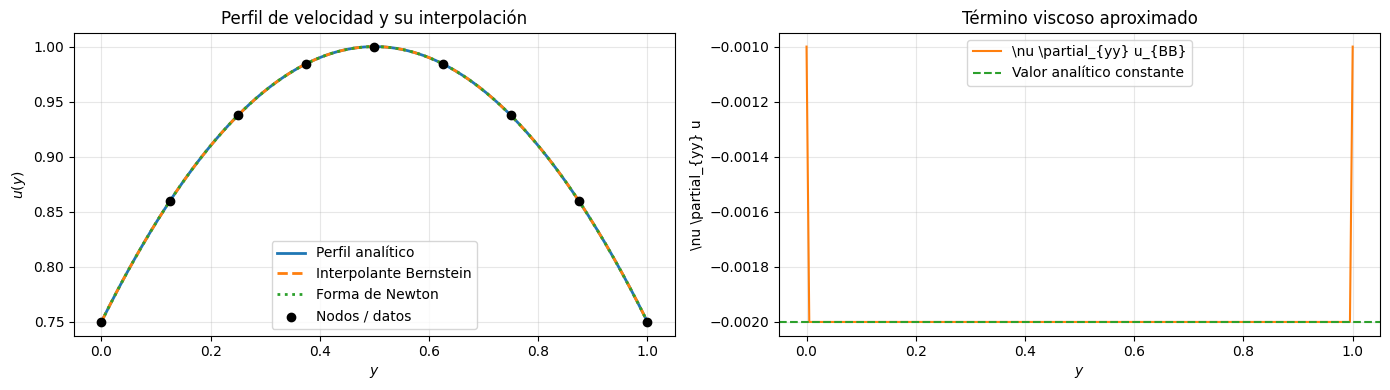

Error máximo en el término viscoso: 1.000e-03


In [4]:
second_derivative_interp = np.gradient(np.gradient(u_interp, y_dense), y_dense)
viscous_term_interp = nu * second_derivative_interp
viscous_term_analytic = -2.0 * nu

max_viscous_error = np.max(np.abs(viscous_term_interp - viscous_term_analytic))

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(y_dense, u_dense, label='Perfil analítico', linewidth=2)
axs[0].plot(y_dense, u_interp, '--', label='Interpolante Bernstein', linewidth=2)
axs[0].plot(y_dense, u_newton, ':', label='Forma de Newton', linewidth=2)
axs[0].scatter(y_nodes, u_nodes, color='black', label='Nodos / datos', zorder=5)
axs[0].set_title('Perfil de velocidad y su interpolación')
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$u(y)$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(y_dense, viscous_term_interp, color='tab:orange', label=r'\nu \partial_{yy} u_{BB}')
axs[1].axhline(viscous_term_analytic, color='tab:green', linestyle='--', label='Valor analítico constante')
axs[1].set_title('Término viscoso aproximado')
axs[1].set_xlabel('$y$')
axs[1].set_ylabel(r'\nu \partial_{yy} u')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error máximo en el término viscoso: {max_viscous_error:.3e}")

## Conclusiones breves

- El algoritmo Newton-Bernstein permite obtener los puntos de control de Bernstein a partir de los nodos del perfil de velocidad y reproducir el perfil completo con errores en el rango de $10^{-6}$.
- La segunda derivada de la interpolación reproduce el término viscoso $$\nu \partial_{yy} u$$, de forma que el valor esperado (constante) se mantiene dentro de un margen pequeño.
- Esta libreta se puede extender fácilmente a perfiles medidos o diferentes condiciones de contorno sustituyendo los nodos y funciones analíticas correspondientes.